In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
PROJECT_ROOT = "/Users/srs/Desktop/REGIS/MSDS692- DATA SCIENCE PRACTICUM/practicum_1_mood_detection_using_music_recommendation_system"
os.chdir(PROJECT_ROOT)
print("Working directory set to:", os.getcwd())

Working directory set to: /Users/srs/Desktop/REGIS/MSDS692- DATA SCIENCE PRACTICUM/practicum_1_mood_detection_using_music_recommendation_system


In [3]:
df = pd.read_csv("data/processed/spotify_dataset_with_mood.csv")
print(df.shape)
df.head()

(146833, 12)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,source_dataset,mood_label
0,0.941394,1.096577,1.124668,0.0583,0.1020,0.000000,0.0653,0.140773,0.005845,194754,spotify_dataset_1,Happy / Energetic
1,0.813163,0.673558,0.627369,0.0373,0.0724,0.004210,0.3570,0.829455,-0.746595,162600,spotify_dataset_1,Happy / Energetic
2,0.515902,1.159402,0.954713,0.0742,0.0794,0.000023,0.1100,0.514629,0.073096,176616,spotify_dataset_1,Happy / Energetic
3,0.766534,1.155213,0.881023,0.1020,0.0287,0.000009,0.2040,-0.807640,0.003117,169093,spotify_dataset_1,Angry / Intense
4,0.370186,0.748948,0.690623,0.0359,0.0803,0.000000,0.0833,0.955385,0.072005,189052,spotify_dataset_1,Happy / Energetic


In [4]:
feature_sets = {
    "mood_only": ["valence", "energy"],
    "extended_audio": ["valence", "energy", "danceability", "tempo", "loudness"]
}

for name, cols in feature_sets.items():
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name} missing columns: {missing}")

print("Feature sets ready:", list(feature_sets.keys()))

Feature sets ready: ['mood_only', 'extended_audio']


In [5]:
def build_nn_model(df_in: pd.DataFrame, feature_cols: list, n_neighbors: int = 51):
    X = df_in[feature_cols].apply(pd.to_numeric, errors="coerce")
    valid_mask = X.notna().all(axis=1)

    df_model = df_in.loc[valid_mask].reset_index(drop=True)
    X = X.loc[valid_mask].reset_index(drop=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
    nn.fit(X_scaled)

    return df_model, X_scaled, scaler, nn

In [6]:
def mood_consistency_at_k(df_model, X_scaled, nn, k=10, mood_col="mood_label"):
    if mood_col not in df_model.columns:
        raise ValueError(f"Missing {mood_col} in df_model")

    # kneighbors returns self as first neighbor → request k+1 then skip first
    distances, indices = nn.kneighbors(X_scaled, n_neighbors=k+1)
    neighbor_indices = indices[:, 1:]  # drop self

    query_moods = df_model[mood_col].values
    rec_moods = query_moods[neighbor_indices]  # shape: (n_songs, k)

    # proportion of neighbors with same mood label as query
    same = (rec_moods == query_moods.reshape(-1, 1))
    return same.mean()

In [7]:
def avg_similarity_at_k(X_scaled, nn, k=10):
    distances, indices = nn.kneighbors(X_scaled, n_neighbors=k+1)
    neighbor_distances = distances[:, 1:]  # drop self
    similarity = 1 - neighbor_distances    # cosine similarity approx
    return similarity.mean()

In [10]:
def eval_diversity_and_coverage(df_model, X_scaled, nn, k=10, sample_n=1000, random_state=42):
    """
    Returns:
      - ILS (Intra-List Similarity): average pairwise cosine similarity within each Top-K list
        (Lower = more diverse)
      - Coverage: unique recommended items / total catalog size
    Computed on a sample of queries for efficiency.
    """
    n = len(df_model)
    sample_n = min(sample_n, n)

    rng = np.random.default_rng(random_state)
    query_idx = rng.choice(n, size=sample_n, replace=False)

    distances, indices = nn.kneighbors(X_scaled[query_idx], n_neighbors=k + 1)
    rec_idx = indices[:, 1:]  # drop self

    # Coverage
    unique_recommended = len(np.unique(rec_idx))
    coverage = unique_recommended / n

    # ILS: average pairwise similarity within each recommendation list
    ils_scores = []
    for row in rec_idx:
        vecs = X_scaled[row]              # (k, n_features)
        sim = cosine_similarity(vecs)     # (k, k)
        tri = sim[np.triu_indices(k, 1)]  # upper triangle without diagonal
        ils_scores.append(tri.mean())

    ils = float(np.mean(ils_scores))
    return ils, coverage


In [13]:
results = []
K = 10
COVERAGE_SAMPLE_N = 1000  # increase to 2000 if you want; keep small for speed

for fs_name, cols in feature_sets.items():
    print(f"Evaluating feature_set={fs_name} with features={cols}")

    df_model, X_scaled, scaler, nn = build_nn_model(df, cols, n_neighbors=51)

    # FULL-dataset metrics (may take time for large N)
    mood_cons = mood_consistency_at_k(df_model, X_scaled, nn, k=K)
    avg_sim = avg_similarity_at_k(X_scaled, nn, k=K)

    # Sampled metrics (fast)
    ils, coverage = eval_diversity_and_coverage(
        df_model, X_scaled, nn, k=K, sample_n=COVERAGE_SAMPLE_N, random_state=42
    )

    results.append({
        "feature_set": fs_name,
        "k": K,
        "mood_consistency_at_k": round(float(mood_cons), 4),
        "avg_similarity_at_k": round(float(avg_sim), 4),
        "intra_list_similarity_ILS": round(float(ils), 4),
        "catalog_coverage": round(float(coverage), 4),
        "coverage_sample_n": min(COVERAGE_SAMPLE_N, len(df_model)),
        "n_songs_used": len(df_model),
        "features": ", ".join(cols)
    })

eval_df = pd.DataFrame(results)
eval_df


Evaluating feature_set=mood_only with features=['valence', 'energy']
Evaluating feature_set=extended_audio with features=['valence', 'energy', 'danceability', 'tempo', 'loudness']


,feature_set,k,mood_consistency_at_k,avg_similarity_at_k,intra_list_similarity_ILS,catalog_coverage,coverage_sample_n,n_songs_used,features
0,mood_only,10,0.9567,1.0000,1.0000,0.0656,1000,146833,"valence, energy"
1,extended_audio,10,0.9509,0.9954,0.9921,0.0656,1000,146833,"valence, energy, danceability, tempo, loudness"


In [14]:
os.makedirs("reports", exist_ok=True)
eval_df.to_csv("reports/week5_evaluation_summary.csv", index=False)
print("Saved: reports/week5_evaluation_summary.csv")

Saved: reports/week5_evaluation_summary.csv


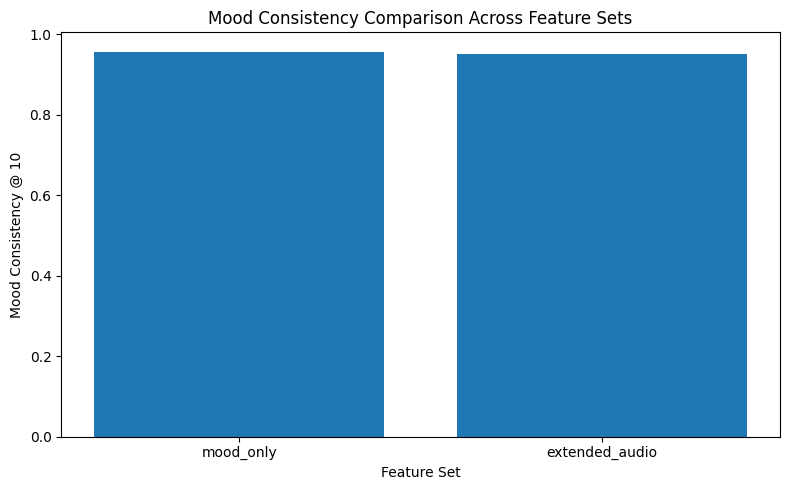

Saved: reports/figures/week5_mood_consistency_comparison.png


In [15]:
os.makedirs("reports/figures", exist_ok=True)

plt.figure(figsize=(8, 5))
plt.bar(eval_df["feature_set"], eval_df["mood_consistency_at_k"])
plt.xlabel("Feature Set")
plt.ylabel(f"Mood Consistency @ {K}")
plt.title("Mood Consistency Comparison Across Feature Sets")
plt.tight_layout()
plt.savefig("reports/figures/week5_mood_consistency_comparison.png", dpi=200)
plt.show()

print("Saved: reports/figures/week5_mood_consistency_comparison.png")

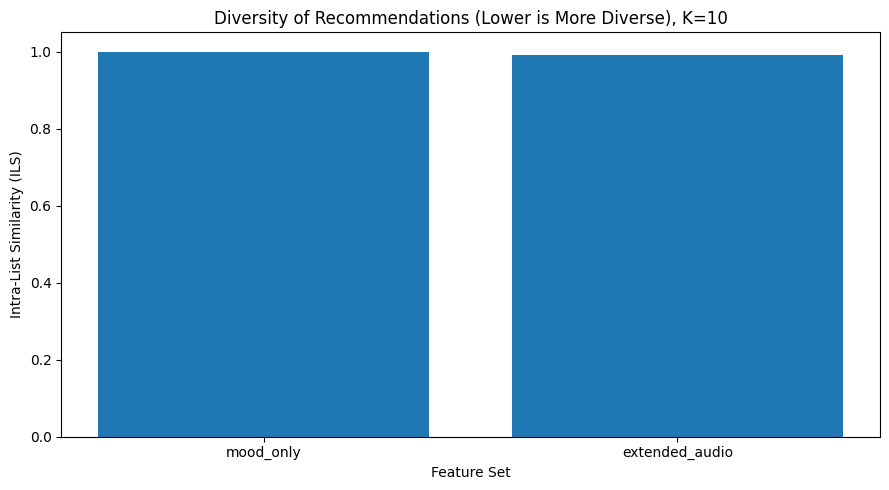

Saved: reports/figures/week5_diversity_ILS_comparison.png


In [16]:
plt.figure(figsize=(9, 5))
plt.bar(eval_df["feature_set"], eval_df["intra_list_similarity_ILS"])
plt.xlabel("Feature Set")
plt.ylabel("Intra-List Similarity (ILS)")
plt.title(f"Diversity of Recommendations (Lower is More Diverse), K={K}")
plt.tight_layout()
plt.savefig("reports/figures/week5_diversity_ILS_comparison.png", dpi=200)
plt.show()

print("Saved: reports/figures/week5_diversity_ILS_comparison.png")

In [17]:
eval_df.sort_values("feature_set")

,feature_set,k,mood_consistency_at_k,avg_similarity_at_k,intra_list_similarity_ILS,catalog_coverage,coverage_sample_n,n_songs_used,features
1,extended_audio,10,0.9509,0.9954,0.9921,0.0656,1000,146833,"valence, energy, danceability, tempo, loudness"
0,mood_only,10,0.9567,1.0000,1.0000,0.0656,1000,146833,"valence, energy"
